In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
%matplotlib inline


In [2]:
import sys
sys.path.append('/home/courtney/voxelmorph/src')
import os
import glob
import random
from argparse import ArgumentParser

# third party
import tensorflow as tf
import scipy.io as sio
import numpy as np
from keras.backend.tensorflow_backend import set_session
import keras.backend as K
from scipy.interpolate import interpn
from neuron.plot import slices
import matplotlib.pyplot as plt
import neuron.utils as nrn_utils
import neuron.layers as nrn_layers

# project
sys.path.append('../ext/medipy-lib')
import medipy
import networks
from medipy.metrics import dice
import datagenerators
import dense_3D_spatial_transformer


/afs/csail.mit.edu/u/c/courtney/.local/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
def restrict_GPU_tf(gpuid, memfrac=0, use_cpu=False):
    """
        gpuid: str, comma separated list "0" or "0,1" or even "0,1,3"
        memfrac: float, fraction of memory. By default grows dynamically
    """
    if not use_cpu:
        os.environ["CUDA_VISIBLE_DEVICES"] = gpuid

        config = tf.ConfigProto()
        if memfrac == 0:
            config.gpu_options.allow_growth = True
        else:
            config.gpu_options.per_process_gpu_memory_fraction = memfrac
        tf.Session(config=config)
        print("Using GPU:{} with {:.0f}% of the memory".format(gpuid, memfrac*100))
    else:
        os.environ["CUDA_VISIBLE_DEVICES"] = ""
        print("Using CPU")

In [4]:
# Keras 
def restrict_GPU_keras(gpuid, memfrac=0, use_cpu=False):
    """
        gpuid: str, comma separated list "0" or "0,1" or even "0,1,3"
        memfrac: float, fraction of memory. By default grows dynamically
    """
    if not use_cpu:
        os.environ["CUDA_VISIBLE_DEVICES"] = gpuid

        config = tf.ConfigProto()
        if memfrac == 0:
            config.gpu_options.allow_growth = True
        else:
            config.gpu_options.per_process_gpu_memory_fraction = memfrac
        set_session(tf.Session(config=config))
        print("Using GPU:{} with {:.0f}% of the memory".format(gpuid, memfrac*100))
    else:
        os.environ["CUDA_VISIBLE_DEVICES"] = ""
        print("Using CPU")

In [5]:
base_data_dir = '/data/ddmg/voxelmorph/data/t1_mix/proc/resize256-crop_x32-adnisel/'
val_vol_names = glob.glob(base_data_dir + 'validate/vols/*.npz')
val_seg_dir = base_data_dir + 'validate/asegs/'

# load atlas from provided files. This atlas is 160x192x224.
atlas = np.load('../data/atlas_norm.npz')
atlas_vol = atlas['vol'][np.newaxis,...,np.newaxis]

gpu_id = 0

In [6]:
def interp_upsampling(V):
    """ 
    upsample a field by a factor of 2
    TODO: should switch this to use neuron.utils.interpn()
    """

    [xx, yy, zz] = nrn_utils.volshape_to_ndgrid([f*2 for f in V.get_shape().as_list()[1:4]])
    xx = tf.cast(xx, 'float32')
    yy = tf.cast(yy, 'float32')
    zz = tf.cast(zz, 'float32')
    xx = tf.expand_dims(xx/2-xx, 0)
    yy = tf.expand_dims(yy/2-yy, 0)
    zz = tf.expand_dims(zz/2-zz, 0)
    offset = tf.stack([xx, yy, zz], 4)

    # V = nrn_utils.transform(V, offset)
    V = nrn_layers.SpatialTransformer(interp_method='linear')([V, offset])

    return V

In [9]:
def meshgrid(height, width, depth):
    x_t = tf.matmul(tf.ones(shape=tf.stack([height, 1])),
                    tf.transpose(tf.expand_dims(tf.linspace(0.0,
                                                            tf.cast(width, tf.float32)-1.0, width), 1), [1, 0]))
    y_t = tf.matmul(tf.expand_dims(tf.linspace(0.0,
                                               tf.cast(height, tf.float32)-1.0, height), 1),
                    tf.ones(shape=tf.stack([1, width])))

    x_t = tf.tile(tf.expand_dims(x_t, 2), [1, 1, depth])
    y_t = tf.tile(tf.expand_dims(y_t, 2), [1, 1, depth])

    z_t = tf.linspace(0.0, tf.cast(depth, tf.float32)-1.0, depth)
    z_t = tf.expand_dims(tf.expand_dims(z_t, 0), 0)
    z_t = tf.tile(z_t, [height, width, 1])

    return x_t, y_t, z_t

In [7]:
def interp_downsampling(V):
#     [xx, yy, zz] = nrn_utils.volshape_to_ndgrid([int(f/(2)) for f in V.get_shape().as_list()[1:4]])
    [xx, yy, zz] = meshgrid(tf.cast(tf.shape(V)[1]/2, tf.int32), 
                            tf.cast(tf.shape(V)[2]/2, tf.int32),
                            tf.cast(tf.shape(V)[3]/2, tf.int32))
#     sess = tf.Session()
#     with sess.as_default():
#         # print the loss. 
#         print(xx.eval())
#         print(yy.eval())
#         print(zz.eval())

    xx = tf.cast(xx, 'float32')
    yy = tf.cast(yy, 'float32')
    zz = tf.cast(zz, 'float32')
    xx = tf.expand_dims(2*xx-xx, 0)
    yy = tf.expand_dims(2*yy-yy, 0)
    zz = tf.expand_dims(2*zz-zz, 0)

    offset = tf.stack([xx, yy, zz], 4)

    V = dense_3D_spatial_transformer.Dense3DSpatialTransformer()([V, offset])
    
    
    return V
#     return offset

Using GPU:0 with 0% of the memory
Using GPU:0 with 0% of the memory
(1, 40, 48, 56, 30)
image shape (20, 24, 28, 30)
original shape (40, 48, 56, 30)


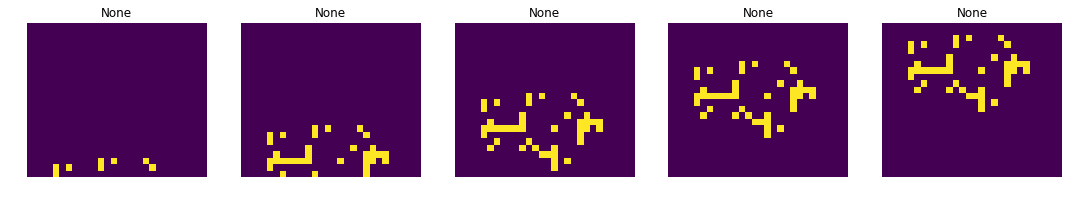

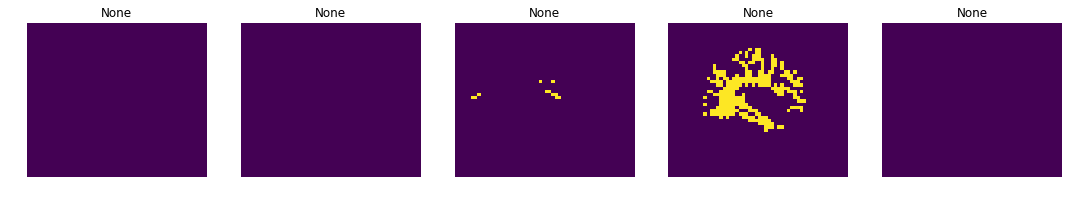

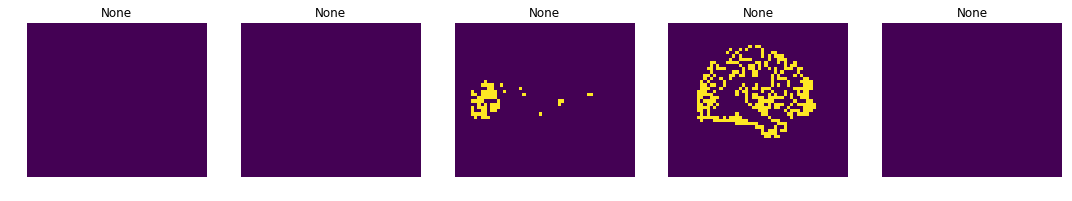

0.0


In [8]:
vol_size=(160,192,224)
nf_enc=[16,32,32,32]
nf_dec=[32,32,32,32]

restrict_GPU_tf(str(gpu_id))
restrict_GPU_keras(str(gpu_id))


"""
test

nf_enc and nf_dec
#nf_dec = [32,32,32,32,32,16,16,3]
# This needs to be changed. Ideally, we could just call load_model, and we wont have to
# specify the # of channels here, but the load_model is not working with the custom loss...
"""  

gpu = '/gpu:' + str(gpu_id)

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
config.allow_soft_placement = True
set_session(tf.Session(config=config))

train_labels = sio.loadmat('../data/labels.mat')['labels'][0]
n_labels = train_labels.shape[0]

# atlas_vol = atlas['vol']
# atlas_seg = atlas['seg']
# atlas_vol = np.reshape(atlas_vol, (1,)+atlas_vol.shape+(1,))
# atlas_seg = np.reshape(atlas_seg, (1,)+atlas_seg.shape+(1,))

# atlas_seg = datagenerators.split_seg_into_channels(atlas_seg, train_labels)
# atlas_seg = datagenerators.downsample(atlas_seg)

val_example_gen = datagenerators.example_gen(val_vol_names, return_segs=True, seg_dir=val_seg_dir)

# train. Note: we use train_on_batch and design out own print function as this has enabled 
# faster development and debugging, but one could also use fit_generator and Keras callbacks.
total_loss = 0
n_points = 1
for step in range(n_points):
    X = next(val_example_gen)
    X_seg = X[1]

    X_seg = datagenerators.split_seg_into_channels(X_seg, train_labels)
    X_seg = datagenerators.downsample(X_seg)
    X_seg = datagenerators.downsample(X_seg)

    # get data

    print(X_seg.shape)
    ds = interp_downsampling(tf.convert_to_tensor(X_seg, np.float32))
    
    sess = tf.Session()

    with sess.as_default():
        # print the loss. 
        ds_val = ds.eval()

    
    image = np.squeeze(ds_val)
    original = np.squeeze(X_seg)

    print('image shape', image.shape)
    print('original shape', original.shape)
    
    import scipy.io as sio
    sio.savemat('data.mat', {'image': image, 'original': original})
#     slices([image[0, :, :, 0], image[20, :, :, 0], image[40, :, :, 0], image[60, :, :, 0], image[79, :, :, 0]])
    slices([image[0, :, :, 0], image[5, :, :, 0], image[10, :, :, 0], image[15, :, :, 0], image[19, :, :, 0]])

    slices([original[0, :, :, 0], original[10, :, :, 0], original[20, :, :, 0], original[30, :, :, 0], original[39, :, :, 0]])
    slices([original[0, :, :, 1], original[10, :, :, 1], original[20, :, :, 1], original[30, :, :, 1], original[39, :, :, 1]])


print(total_loss/n_points)


Using GPU:0 with 0% of the memory
Using GPU:0 with 0% of the memory
0 0 0.0007876607091974217


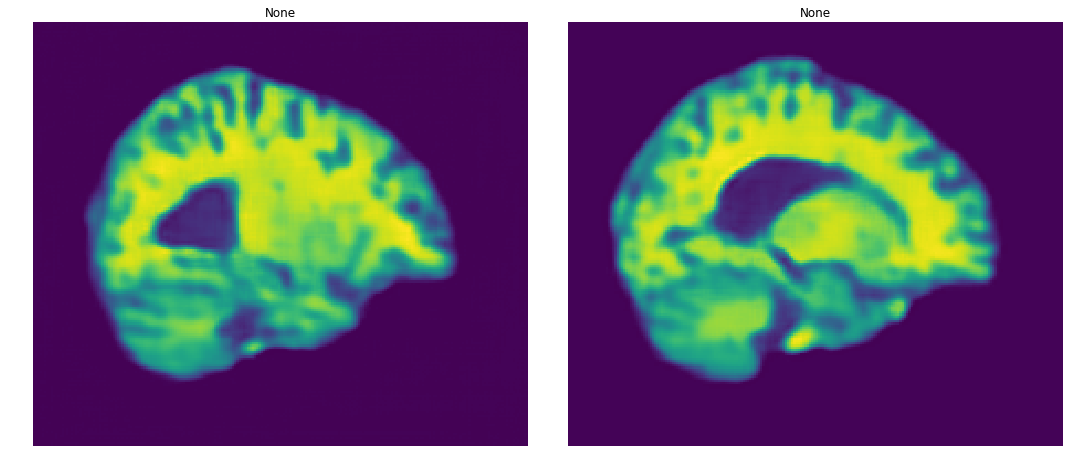

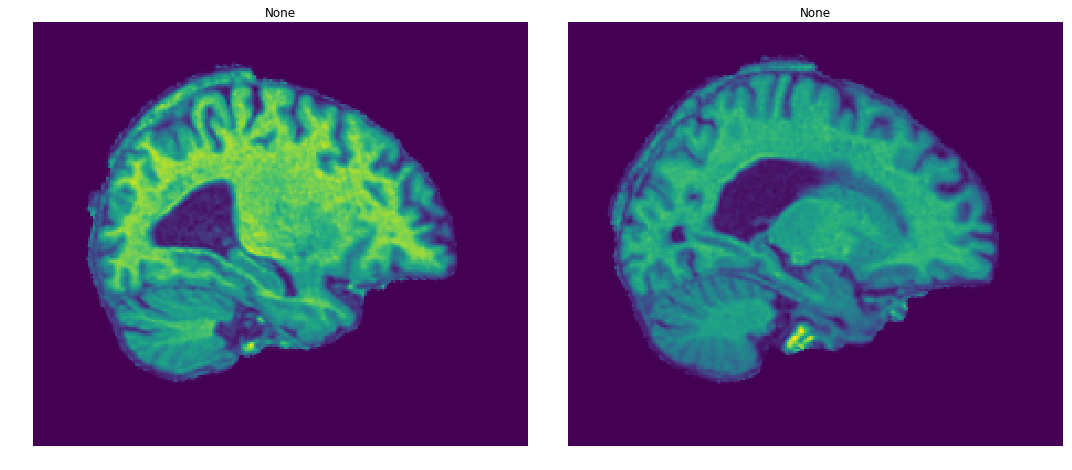

1 0 0.0006658012666107805
2 0 0.0005387770891960504
3 0 0.0004595036123593028
4 0 0.0003542980449612104
5 0 0.0007020013724708148
6 0 0.0006297789375083473
7 0 0.0005775693261276085
8 0 0.0006121237742658392
9 0 0.0004069234411414796
0.0005734437573838855


In [9]:
model_name = 'autoencoder_4'
# model_name = 'autoencoder_3'
gpu_id = 0
iter_num = 135400
# iter_num = 50000
vol_size=(160,192,224)
nf_enc=[16,32,32,32]
nf_dec=[32,32,32,32]

restrict_GPU_tf(str(gpu_id))
restrict_GPU_keras(str(gpu_id))


"""
test

nf_enc and nf_dec
#nf_dec = [32,32,32,32,32,16,16,3]
# This needs to be changed. Ideally, we could just call load_model, and we wont have to
# specify the # of channels here, but the load_model is not working with the custom loss...
"""  

gpu = '/gpu:' + str(gpu_id)

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
config.allow_soft_placement = True
set_session(tf.Session(config=config))

# load weights of model
with tf.device(gpu):
    full_model, train_model = networks.autoencoder(vol_size, nf_enc, nf_dec)
    full_model.load_weights('../models/' + model_name +
                     '/' + str(iter_num) + '.h5')

val_example_gen = datagenerators.example_gen(val_vol_names)

# train. Note: we use train_on_batch and design out own print function as this has enabled 
# faster development and debugging, but one could also use fit_generator and Keras callbacks.
total_loss = 0
n_points = 10
for step in range(n_points):

    # get data
    X = next(val_example_gen)[0]

    # get output
    output, enc = full_model.predict([X])

    loss = tf.reduce_mean(tf.square(output - X))

    sess = tf.Session()
    with sess.as_default():
        # print the loss. 
        loss_val = loss.eval()
        print(step, 0, loss_val)
        total_loss += loss_val
        
    image = np.squeeze(output)
    if step == 0:
        slices([image[50], image[100]])
        original = np.squeeze(X)
        slices([original[50], original[100]])

print(total_loss/n_points)


Using GPU:0 with 0% of the memory
Using GPU:0 with 0% of the memory
0 0 0.0002911045807524825


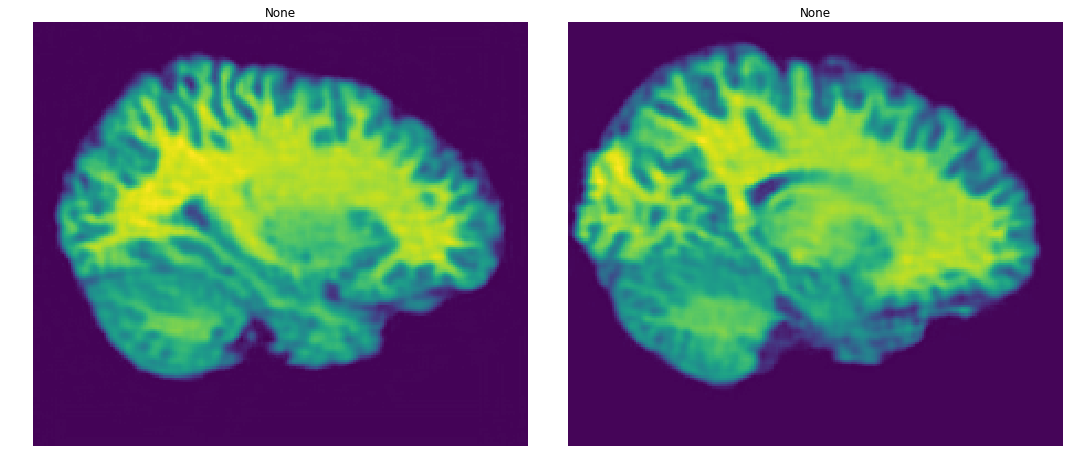

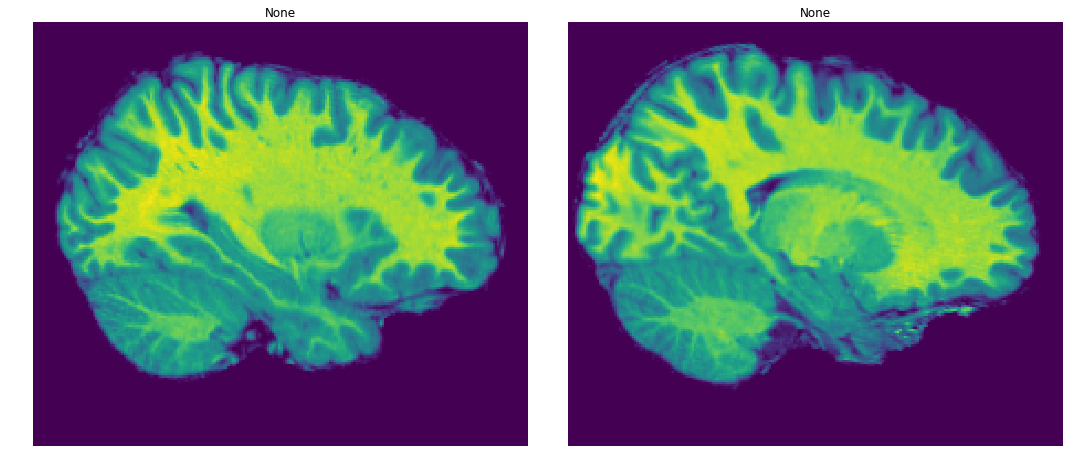

1 0 0.0003772536865830978
2 0 0.00031884201674736446
3 0 0.0001757636572189224
4 0 0.00026005210884911634
5 0 0.0003387799397920976
6 0 0.00011988342064844051
7 0 0.00037286401321017475
8 0 0.00017017768484605322


ValueError: GraphDef cannot be larger than 2GB.

In [10]:
# model_name = 'autoencoder_4'
model_name = 'autoencoder_3'
gpu_id = 0
# iter_num = 135400
iter_num = 50000
vol_size=(160,192,224)
nf_enc=[16,32,32]
nf_dec=[32,32,32]

restrict_GPU_tf(str(gpu_id))
restrict_GPU_keras(str(gpu_id))


"""
test

nf_enc and nf_dec
#nf_dec = [32,32,32,32,32,16,16,3]
# This needs to be changed. Ideally, we could just call load_model, and we wont have to
# specify the # of channels here, but the load_model is not working with the custom loss...
"""  

gpu = '/gpu:' + str(gpu_id)

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
config.allow_soft_placement = True
set_session(tf.Session(config=config))

# load weights of model
with tf.device(gpu):
    full_model, train_model = networks.autoencoder(vol_size, nf_enc, nf_dec)
    full_model.load_weights('../models/' + model_name +
                     '/' + str(iter_num) + '.h5')

val_example_gen = datagenerators.example_gen(val_vol_names)

# train. Note: we use train_on_batch and design out own print function as this has enabled 
# faster development and debugging, but one could also use fit_generator and Keras callbacks.
total_loss = 0
n_points = 10
for step in range(n_points):

    # get data
    X = next(val_example_gen)[0]

    # get output
    output, enc = full_model.predict([X])

    loss = tf.reduce_mean(tf.square(output - X))

    sess = tf.Session()
    with sess.as_default():
        # print the loss. 
        loss_val = loss.eval()
        print(step, 0, loss_val)
        total_loss += loss_val
        
    image = np.squeeze(output)
    if step == 0:
        slices([image[50], image[100]])
        original = np.squeeze(X)
        slices([original[50], original[100]])

print(total_loss/n_points)


Using GPU:0 with 0% of the memory
Using GPU:0 with 0% of the memory
0 0 0.00022149995686991862


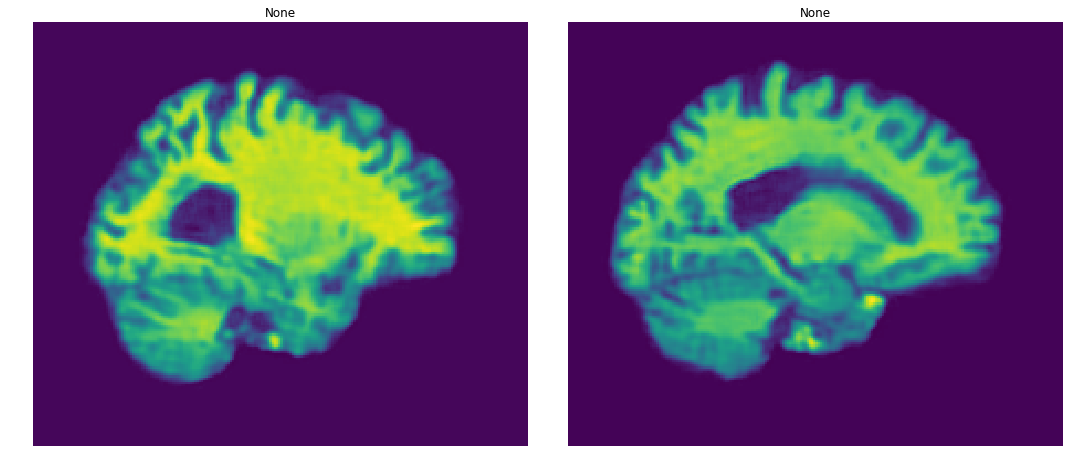

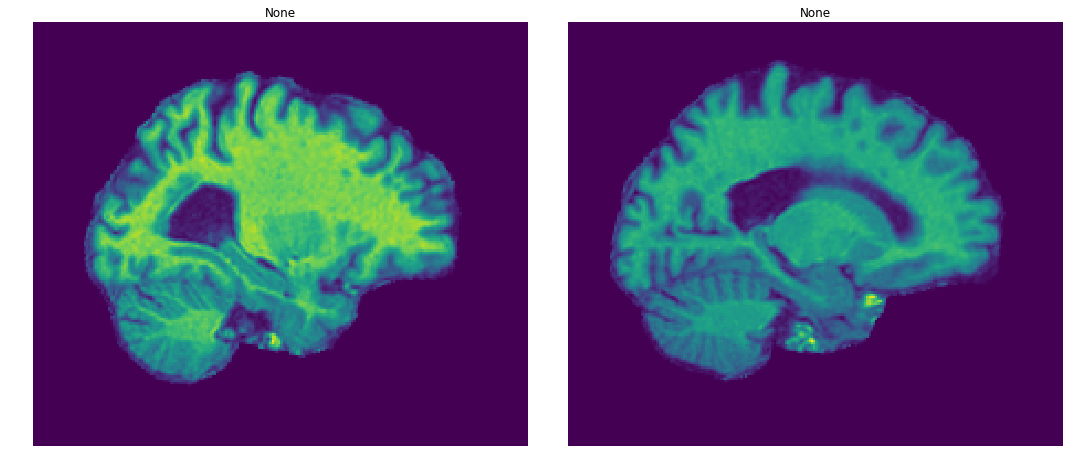

1 0 0.00013294825359792014
2 0 0.0003973191417779938
3 0 0.00027133334719114363
4 0 0.00021783348311728415
5 0 0.00012238763351587217
6 0 0.00011829574438623683
7 0 0.00012497667669387645
8 0 0.0003303315435132265
9 0 0.00023529675957335096
0.00021722225402368234


In [6]:
# model_name = 'autoencoder_4'
model_name = 'autoencoder_3'
gpu_id = 0
iter_num = 135400
# iter_num = 50000
vol_size=(160,192,224)
nf_enc=[16,32,32]
nf_dec=[32,32,32]

restrict_GPU_tf(str(gpu_id))
restrict_GPU_keras(str(gpu_id))


"""
test

nf_enc and nf_dec
#nf_dec = [32,32,32,32,32,16,16,3]
# This needs to be changed. Ideally, we could just call load_model, and we wont have to
# specify the # of channels here, but the load_model is not working with the custom loss...
"""  

gpu = '/gpu:' + str(gpu_id)

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
config.allow_soft_placement = True
set_session(tf.Session(config=config))

# load weights of model
with tf.device(gpu):
    full_model, train_model = networks.autoencoder(vol_size, nf_enc, nf_dec)
    full_model.load_weights('../models/' + model_name +
                     '/' + str(iter_num) + '.h5')

val_example_gen = datagenerators.example_gen(val_vol_names)

# train. Note: we use train_on_batch and design out own print function as this has enabled 
# faster development and debugging, but one could also use fit_generator and Keras callbacks.
total_loss = 0
n_points = 10
for step in range(n_points):

    # get data
    X = next(val_example_gen)[0]

    # get output
    output, enc = full_model.predict([X])

    loss = tf.reduce_mean(tf.square(output - X))

    sess = tf.Session()
    with sess.as_default():
        # print the loss. 
        loss_val = loss.eval()
        print(step, 0, loss_val)
        total_loss += loss_val
        
    image = np.squeeze(output)
    if step == 0:
        slices([image[50], image[100]])
        original = np.squeeze(X)
        slices([original[50], original[100]])

print(total_loss/n_points)
